In [1]:
import os
import logging
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor


from library.commons import check_parameters
from library.datahub import gen_etopo, get_station_data, open_topo

# config logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Setup

In [2]:
# set your domain, lon_min, lon_max, lat_min, lat_max
DOMAIN = [-80, -25, -60, 15]

# set your horizontal resolution in degrees
RES = 0.25

# set variables list
variables = ['tmax', 'tmin']

# set your start and end date
START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2024, 1, 1)

# set param grid, it'll be used to RandomForest tuning
param_grid = {
                'n_estimators': [100, 200, 300],  # number of trees
                'max_depth': [10, 20, None],  # max deep
                'min_samples_split': [2, 5, 10],  # min samples number to split a node 
                'min_samples_leaf': [1, 2, 4],  # min samples number by leaf
                'bootstrap': [True, False]  # use or not bootstrap
            }


# if true, save intermediate files, seeking to reduce the use of external APIs (meteostat and open topo data)
SAVE_STATIC_FILES = True

# set engine to handle with netcdf files
nc_engine = 'netcdf4'  # options 'netcdf4' and 'xarray'

# Checkings

Let's check the consistence of our settings before starting the process

In [3]:
NC_ENGINE = nc_engine.lower()  # avoid upper case errors
VARIABLES = [variables] if not isinstance(variables, list) else variables  # check right type

# this function will raise an error if the params are not consistents
check_parameters(NC_ENGINE, DOMAIN, RES, START_DATE, END_DATE, VARIABLES)

True

# Pre-processing

In [4]:
# set interpolated grid parameters
grid_lat = np.arange(DOMAIN[-2], DOMAIN[-1] + RES, RES)
grid_lon = np.arange(DOMAIN[0], DOMAIN[1] + RES, RES)

dates = pd.date_range(start=START_DATE, end=END_DATE, freq='1D').to_pydatetime()


# Getting stations file

For educational purposes, we'll use Meteostat to retrieve data from weather stations; any other CSV file can be used as long as it follows the same format.

It must be the following columns: station (which informs the id or name string), latitude, longitude and elevation, the column(s) with VARIABLES defined in setup is(are) necessary as well

In [5]:
# set specified domain to get weather station data, format (domain_top, domain_left), (domain_bottom, domain_right)
ws_outpath = f"static/stations_{DOMAIN[0]}_{DOMAIN[1]}_{DOMAIN[2]}_{DOMAIN[3]}_{START_DATE:%Y%m%d}_{END_DATE:%Y%m%d}.csv"

if os.path.exists(ws_outpath):
    logging.info(f"opening weather station file @ {ws_outpath}")
    daily_data = pd.read_csv(ws_outpath)
    
else:

    # get weather station data using meteostat
    daily_data = get_station_data(DOMAIN, START_DATE, END_DATE)
    
    if SAVE_STATIC_FILES:
        logging.info(f"creating csv with data station @ {ws_outpath}")
        daily_data.to_csv(ws_outpath)
    
# dropna and select columns
to_select_colunms = ['time', 'station', 'latitude', 'longitude', 'elevation'] + VARIABLES

try:
    daily_data = daily_data.dropna(subset=VARIABLES).reset_index()
    daily_data = daily_data.loc[:, to_select_colunms]

except KeyError as e:
    raise KeyError(f"there are variables not found in dataframe columns @ {e}")

daily_data['time'] = pd.to_datetime(daily_data['time'])

daily_data.head()

2024-10-03 13:02:51,931 - INFO - opening weather station file @ static/stations_-80_-25_-60_15_20240101_20240101.csv


,time,station,latitude,longitude,elevation,tmax,tmin
0,2024-01-01,69377,4.0700,-73.5500,378.0,31.2,21.0
1,2024-01-01,78792,9.0500,-79.3667,45.0,32.0,24.0
2,2024-01-01,78808,8.9833,-79.5500,66.0,33.0,25.0
3,2024-01-01,78922,14.7667,-60.8833,33.0,28.1,23.7
4,2024-01-01,78925,14.6000,-61.0000,5.0,30.0,22.0


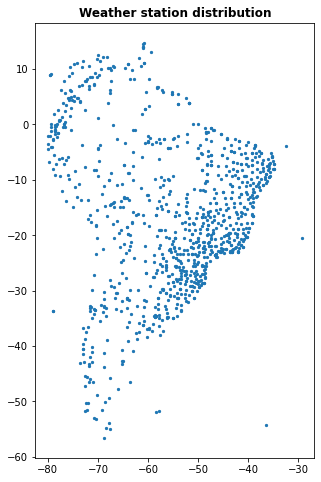

In [6]:
# a simple plot just to check the weather stations distribution
fig, ax = plt.subplots(figsize=(5, 8))
ax.scatter(daily_data['longitude'].values, daily_data['latitude'].values, s=5)
ax.set_title(f"Weather station distribution", weight='bold')
plt.show()
plt.close()

# Opening topography file

You can use another topography file, the final topo array must be in meters unit

In [7]:
topo_pathfile = f'static/ETOPO_lon_{DOMAIN[0]}_{DOMAIN[1]}_lat_{DOMAIN[2]}_{DOMAIN[3]}_r{RES}.nc'
should_open_topo = True

# you can use a specific topography file
# to ensure the right progress of the code, the netcdf file must be the following pattern
# dimensions: y (with latitude values in degrees) ; x (with longitude values in degrees)
# variable: z (y, x) - 2D array with elevation values in meters

# topo_pathfile = 'static/<your_netcdf_topography_file>.nc'  


# create etopo file from opentopodata api, it may take some time according to domain and horizontal resolution 
if not os.path.exists(topo_pathfile):
    if SAVE_STATIC_FILES:
        logging.info(f'Creating topo file for specific domain and resolution @ {DOMAIN} - {RES}')
        gen_etopo(grid_lat, grid_lon, topo_pathfile=topo_pathfile)
        
    else:
        topo = gen_etopo(grid_lat, grid_lon, topo_pathfile=topo_pathfile, save_output=False)
        should_open_topo = False
        


2024-10-03 13:02:52,650 - INFO - 
Checking boundaries:
    expected domain: [-80, -25, -60, 15]
    lats: (-60.0, 15.0)
    lons: (-80.0, -25.0)
        


CPU times: user 66.1 ms, sys: 4.97 ms, total: 71.1 ms
Wall time: 70.7 ms


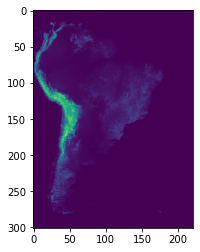

In [8]:
%%time
if should_open_topo:
    topo, lats_, lons_ = open_topo(topo_pathfile, grid_lat, grid_lon, nc_engine=NC_ENGINE)
    
    logging.info(
        f"""
Checking boundaries:
    expected domain: {DOMAIN}
    lats: {lats_[0], lats_[-1]}
    lons: {lons_[0], lons_[-1]}
        """
         )

topo[topo < 0] = 0  # avoid negative altitudes
plt.imshow(topo[::-1])

# Applying interpol

This is only a experimental test, the objective is shows that we can use ML solution to create a interpolated field, but we should not use it before a deep validation and comparison with traditional interpolation methods.

## RandomForest

The Random Forest model is a machine learning algorithm based on decision trees. The main idea behind Random Forest is to combine several independent decision trees to improve the accuracy of predictions.


A single decision tree can make errors because it relies on just one sequence of decisions. Random Forest addresses this by building multiple decision trees and then combining the results. Each tree is trained on a different sample of the data and makes its own decisions. The final result is the average (for regression problems) or the majority vote of the trees (for classification).

### Random Forest Model Explanation

The *Random Forest* algorithm is a powerful machine learning method that combines multiple decision trees to make more accurate predictions. Let's break it down step by step.

#### 1. What is a Decision Tree?

A decision tree is a model that makes decisions by asking a series of "yes/no" questions about the data. Each question splits the data further until it reaches a final decision.

For example, to decide whether a person likes a movie, we might ask:
- Does the person like action movies?
- Does the person prefer comedies or dramas?

Each of these questions creates a "node" in the tree, and the data follows a path until a "leaf" (final decision) is reached.

#### 2. What is a Random Forest?

A *Random Forest* builds multiple decision trees and combines their predictions. Each tree is trained on a different random sample of the data and considers only a random subset of features when making splits. The idea is that by averaging the results of many trees, the model becomes more accurate and robust.

#### 3. How Does Random Forest Work?

1. **Create multiple random samples** from the original data (this is called bootstrapping).
2. For each sample, **build a decision tree**.
3. Each tree makes decisions based on only a random subset of features, which helps prevent one feature from dominating the predictions.
4. When making a prediction, each tree "votes":
   - For classification, the most voted class is the final prediction.
   - For regression, the final prediction is the average of all trees' predictions.

#### 4. Equations Involved

##### Classification:

For classification, the final prediction $\hat{y}_i$ for an observation $i$ is given by the majority vote among the $T$ trees:

$$
\hat{y}_i = \text{mode}\left\{ y_i^{(1)}, y_i^{(2)}, \dots, y_i^{(T)} \right\}
$$

where $y_i^{(t)}$ is the prediction of the $t$-th tree.

##### Regression:

For regression, the final prediction $\hat{y}_i$ for an observation $i$ is the average of the predictions from all $T$ trees:

$$
\hat{y}_i = \frac{1}{T} \sum_{t=1}^{T} \hat{y}_i^{(t)}
$$

#### 5. Impurity Measures for Splitting

To decide the best way to split the data at each node, we measure how "pure" or "impure" the resulting groups are. Two common impurity measures are the **Gini Index** and **Entropy**.

##### Gini Index:

The Gini Index $G(p)$ is defined as:

$$
G(p) = 1 - \sum_{i=1}^{C} p_i^2
$$

where:
- $p_i$ is the probability of class $i$,
- $C$ is the total number of classes.

A lower Gini Index means the node is more "pure," meaning the data in that node is more homogeneous.

##### Entropy:

Entropy $H(p)$ is another way to measure the impurity of a node:

$$
H(p) = -\sum_{i=1}^{C} p_i \log_2(p_i)
$$

Lower entropy also means a more homogeneous group.

#### 6. Bagging and Feature Randomness

*Random Forest* uses two key concepts to improve the model's accuracy and reduce overfitting:

1. **Bagging (Bootstrap Aggregating):** Each tree is trained on a random sample of the data, allowing the model to be more robust by reducing variance.
2. **Random Feature Selection:** At each node, a random subset of features is selected to determine the best split. This ensures no single feature dominates the model, reducing overfitting.



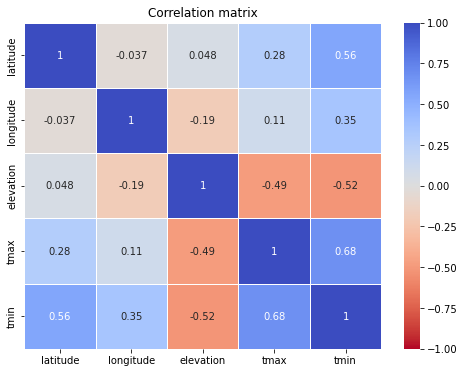

In [9]:
corr = daily_data[['latitude', 'longitude', 'elevation'] + VARIABLES].corr()

# check corelation between features
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm_r', vmin=-1, vmax=1, center=0, 
            annot_kws={"size": 10}, linewidths=0.5)

plt.title('Correlation matrix')
plt.show()

In [10]:
interpolated_ds = {}
times = daily_data['time'].unique()
for variable in VARIABLES:
    interpolated_ds[variable] = []
    
    for date in times:
        
        logging.info(f"Starting {variable} interpolation @ {date:%Y%m%d}")
        
        df_date = daily_data.loc[daily_data['time'] == date]
        
        values_ws = df_date[variable].values
        elevation_ws = df_date['elevation'].values
        
        # init RF regressor
        rf = RandomForestRegressor(random_state=42)

        # set grid search (GS) for parameters tuning (using 5 folds)
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                                   cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error')

        # prepare data
        X_train = df_date[['latitude', 'longitude', 'elevation']].values
        y_train = values_ws

        # fit GS
        grid_search.fit(X_train, y_train)

        # show best parameters
        print(f"Best parameters: {grid_search.best_params_}")

        # get best model
        best_rf_model = grid_search.best_estimator_
        

        # prepare grid to predict
        grid_lat_lon_alt = np.column_stack((np.repeat(grid_lat, len(grid_lon)), 
                                            np.tile(grid_lon, len(grid_lat)), 
                                            topo.flatten()))
        
        # gen results
        preds = best_rf_model.predict(grid_lat_lon_alt)


        # reshape
        grid = preds.reshape(len(grid_lat), len(grid_lon))


        interpolated_ds[variable].append(grid) 

        logging.info(f"Interpolation of {variable} on {date:%Y%m%d} done")

2024-10-03 13:02:53,673 - INFO - Starting tmax interpolation @ 20240101


Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


2024-10-03 13:07:52,798 - INFO - Interpolation of tmax on 20240101 done
2024-10-03 13:07:52,799 - INFO - Starting tmin interpolation @ 20240101


Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


2024-10-03 13:12:46,013 - INFO - Interpolation of tmin on 20240101 done


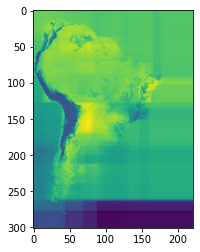

In [11]:
plt.imshow(interpolated_ds['tmax'][0][::-1])